In [ ]:
!gdown --id 1scuFwqh8s7KIYAfZW1Eu6088ZAK2SI-v

In [ ]:
!unzip Emotional\ Speech\ Dataset\ (ESD).zip

In [ ]:
!mkdir model

In [ ]:
!mkdir model/n2a

In [ ]:
!mkdir validation_output

In [ ]:
import glob
import shutil
import os

In [ ]:
files = glob.glob('Emotional Speech Dataset (ESD)/*/*/*/*.wav')
for file in files:
    sett = file.split('/')[-2]
    emotion = file.split('/')[-3]
    dest = 'data/'+sett+'/'+emotion+'/'
    os.makedirs(os.path.dirname(dest), exist_ok=True) 
    shutil.copy(file, dest)

In [52]:
import os
import numpy as np
import argparse
import time
import librosa
import soundfile

In [53]:
from utils1 import *
from model import CycleGAN

In [54]:
import librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt

In [55]:
%pylab inline
rcParams['figure.figsize'] = (16, 4)

Populating the interactive namespace from numpy and matplotlib


/root/anaconda3/envs/abdelmoez/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [61]:
train_A_dir = 'data/train/Happy/'
train_B_dir = 'data/train/Angry/'
validation_A_dir = 'data/evaluation/Happy/'
validation_B_dir = 'data/evaluation/Angry/'
model_name = 'n2a.ckpt'
model_dir = 'model/n2a/'
output_dir = 'validation_output/'

In [62]:
random_seed = 0
np.random.seed(random_seed)

In [63]:
# set training parameters
num_epochs = 1000
mini_batch_size = 1 # mini_batch_size = 1 is better
generator_learning_rate = 0.0002
generator_learning_rate_decay = generator_learning_rate / 200000
discriminator_learning_rate = 0.0001
discriminator_learning_rate_decay = discriminator_learning_rate / 200000
sampling_rate = 16000
num_mcep = 24
frame_period = 5.0
n_frames = 128
lambda_cycle = 10
lambda_identity = 5

In [64]:
# load audio waveform
wavs_A = load_wavs(wav_dir = train_A_dir, sr = sampling_rate)
wavs_B = load_wavs(wav_dir = train_B_dir, sr = sampling_rate)

### TEST Input

(16000,)


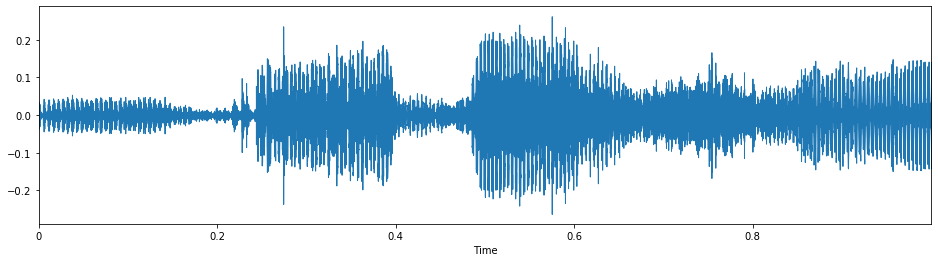

In [65]:
x = wavs_A[1]
print(np.shape(x))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

In [66]:
# extract Pitch contour (f0s), Harmonic spectral envelope (sps) and Aperiodic spectral envelope (aps)
f0s_A, timeaxes_A, sps_A, aps_A, coded_sps_A = world_encode_data(wavs = wavs_A, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)
f0s_B, timeaxes_B, sps_B, aps_B, coded_sps_B = world_encode_data(wavs = wavs_B, fs = sampling_rate, frame_period = frame_period, coded_dim = num_mcep)


In [67]:
# prepare for log Gaussian Normalized Transform 
log_f0s_mean_A, log_f0s_std_A = logf0_statistics(f0s_A)
log_f0s_mean_B, log_f0s_std_B = logf0_statistics(f0s_B)
print('log f0 of Pitch A: Mean %f, Std %f' %(log_f0s_mean_A, log_f0s_std_A))
print('log f0 of Pitch B: Mean %f, Std %f' %(log_f0s_mean_B, log_f0s_std_B))

log f0 of Pitch A: Mean 5.284421, Std 0.280213
log f0 of Pitch B: Mean 5.396624, Std 0.168883


In [68]:
coded_sps_A_transposed = transpose_in_list(lst = coded_sps_A)
coded_sps_B_transposed = transpose_in_list(lst = coded_sps_B)
coded_sps_A_norm, coded_sps_A_mean, coded_sps_A_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_A_transposed)
coded_sps_B_norm, coded_sps_B_mean, coded_sps_B_std = coded_sps_normalization_fit_transoform(coded_sps = coded_sps_B_transposed)
print("Input data fixed.")

Input data fixed.


### F0

(15465,)


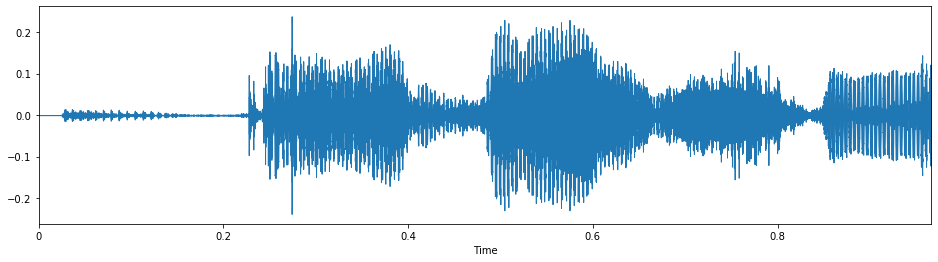

In [69]:
idx = 0
x = wavs_A[idx]
print(np.shape(x))
librosa.display.waveplot(x, sr=sampling_rate)
Audio(x, rate=sampling_rate)

Text(0, 0.5, 'Frequency')

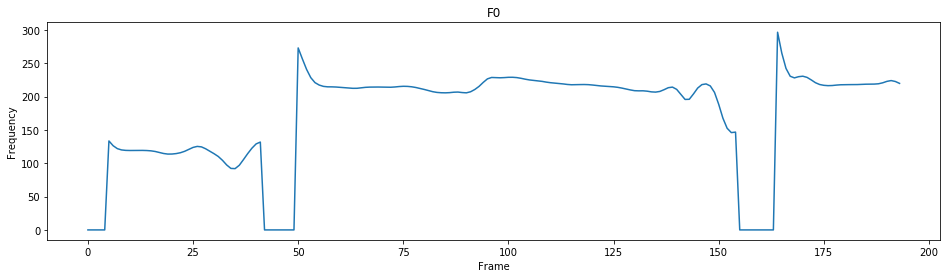

In [70]:
plt.plot(f0s_A[0])
plt.title('F0')
plt.xlabel('Frame')
plt.ylabel('Frequency')

### CHECK preprocessing

In [71]:
print(len(coded_sps_A_norm), np.shape(coded_sps_A_norm[0]))
print(len(coded_sps_B_norm), np.shape(coded_sps_B_norm[0]))
pool_A, pool_B, f0sA, f0sB  = list(coded_sps_A_norm), list(coded_sps_B_norm), list(f0s_A), list(f0s_B)

454 (24, 194)
703 (24, 201)


In [72]:
# Sample proportional to the length
def sample_train_data2(pool_A, pool_B, f0s_A, f0s_B, n_frames=128, max_samples=1000):

#     np.random.shuffle(pool_A)
#     np.random.shuffle(pool_B)
    
    train_data_A = []
    train_data_B = []
    
    while pool_A and pool_B:
        
        idx_A = np.random.randint(len(pool_A))
        idx_B = np.random.randint(len(pool_B))
        data_A, data_B = pool_A[idx_A], pool_B[idx_B]
        data_A_len, data_B_len = data_A.shape[1], data_B.shape[1]   
        f0_A, f0_B = f0s_A[idx_A], f0s_B[idx_B]
        
        if data_A_len < n_frames:
            del pool_A[idx_A]
            del f0s_A[idx_A]
            continue
        
        if data_B_len < n_frames:
            del pool_B[idx_B]
            del f0s_B[idx_B]
            continue
            
        start_A = np.random.randint(data_A_len - n_frames + 1)
        end_A = start_A + n_frames
        if max(f0_A[start_A:end_A]) > 0:
            train_data_A.append(data_A[:,start_A:end_A])
        if start_A >= n_frames and max(f0_A[0:start_A]) > 0:
            pool_A.append(data_A[:,0:start_A])
            f0s_A.append(f0_A[0:start_A])
        if data_A_len - end_A >= n_frames and max(f0_A[end_A:]) > 0:
            pool_A.append(data_A[:,end_A:])
            f0s_A.append(f0_A[end_A:])
        del pool_A[idx_A]
        del f0s_A[idx_A]
 
        start_B = np.random.randint(data_B_len - n_frames + 1)
        end_B = start_B + n_frames
        if max(f0_B[start_B:end_B]) > 0:
            train_data_B.append(data_B[:,start_B:end_B])
        if start_B >= n_frames and max(f0_B[0:start_B]) > 0:
            pool_B.append(data_B[:,0:start_B])
            f0s_B.append(f0_B[0:start_B])
        if data_B_len - end_B >= n_frames and max(f0_B[end_B:]) > 0:
            pool_B.append(data_B[:,end_B:])
            f0s_B.append(f0_B[end_B:])
        del pool_B[idx_B]
        del f0s_B[idx_B]

        # reach maximum data length
        if len(train_data_A) >= max_samples:
            break
    
    num = min(len(train_data_A), len(train_data_B))
    np.random.shuffle(train_data_A)
    np.random.shuffle(train_data_B)
    train_data_A = np.array(train_data_A[0:num])
    train_data_B = np.array(train_data_B[0:num])

    return train_data_A, train_data_B

In [73]:
# dataset_A, dataset_B = sample_train_data(pool_A=pool_A, pool_B=pool_B, n_frames=n_frames, max_samples=1000)
dataset_A, dataset_B = sample_train_data2(pool_A=pool_A, pool_B=pool_B, f0s_A=f0sA, f0s_B=f0sB, n_frames=n_frames, max_samples=1000)
print(np.shape(dataset_A), np.shape(dataset_B))

(391, 24, 128) (391, 24, 128)


In [74]:
# a, b = [1], [1]
# c, d = list(a), list(b)
# c.append(8)
# print(a, b, c, d)

## START Training

In [75]:
n_samples = dataset_A.shape[0]
print(n_samples)

391


In [76]:
# load CycleGAN model (Generator, Discriminator and Loss functions)
model = CycleGAN(num_features = num_mcep)



Instructions for updating:
Use `tf.keras.layers.Conv1D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Use keras.layers.Dense instead.











In [77]:
for j in range(num_epochs):
    print('Epoch: {:07d}'.format(j))
    for i in range(n_samples // mini_batch_size):

        num_iterations = n_samples // mini_batch_size * j + i

        if num_iterations > 10000:
            lambda_identity = 0
        if num_iterations > 200000:
            generator_learning_rate = max(0, generator_learning_rate - generator_learning_rate_decay)
            discriminator_learning_rate = max(0, discriminator_learning_rate - discriminator_learning_rate_decay)

        start = i * mini_batch_size
        end = (i + 1) * mini_batch_size

        generator_loss, discriminator_loss = model.train(input_A = dataset_A[start:end], input_B = dataset_B[start:end], lambda_cycle = lambda_cycle, lambda_identity = lambda_identity, generator_learning_rate = generator_learning_rate, discriminator_learning_rate = discriminator_learning_rate)

        if i % 50 == 0:
            #print('Iteration: %d, Generator Loss : %f, Discriminator Loss : %f' % (num_iterations, generator_loss, discriminator_loss))
            print('Iteration: {:07d}, Generator Learning Rate: {:.7f}, Discriminator Learning Rate: {:.7f}, Generator Loss : {:.3f}, Discriminator Loss : {:.3f}'.format(num_iterations, generator_learning_rate, discriminator_learning_rate, generator_loss, discriminator_loss))


Epoch: 0000000
Iteration: 0000000, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 28.098, Discriminator Loss : 0.562
Iteration: 0000050, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 17.299, Discriminator Loss : 0.344
Iteration: 0000100, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 20.429, Discriminator Loss : 0.384
Iteration: 0000150, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 18.856, Discriminator Loss : 0.452
Iteration: 0000200, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 15.442, Discriminator Loss : 0.482
Iteration: 0000250, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 13.754, Discriminator Loss : 0.536
Iteration: 0000300, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, G

Iteration: 0002696, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 11.903, Discriminator Loss : 0.206
Epoch: 0000007
Iteration: 0002737, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 10.014, Discriminator Loss : 0.229
Iteration: 0002787, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 9.799, Discriminator Loss : 0.058
Iteration: 0002837, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 13.257, Discriminator Loss : 0.132
Iteration: 0002887, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 12.051, Discriminator Loss : 0.230
Iteration: 0002937, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 9.536, Discriminator Loss : 0.193
Iteration: 0002987, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Gen

Iteration: 0005383, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 8.046, Discriminator Loss : 0.043
Iteration: 0005433, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 10.428, Discriminator Loss : 0.041
Epoch: 0000014
Iteration: 0005474, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 9.173, Discriminator Loss : 0.051
Iteration: 0005524, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 8.535, Discriminator Loss : 0.037
Iteration: 0005574, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 11.313, Discriminator Loss : 0.046
Iteration: 0005624, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 9.814, Discriminator Loss : 0.176
Iteration: 0005674, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Gener

Iteration: 0008070, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 7.358, Discriminator Loss : 0.041
Iteration: 0008120, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 6.819, Discriminator Loss : 0.105
Iteration: 0008170, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 8.958, Discriminator Loss : 0.018
Epoch: 0000021
Iteration: 0008211, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 7.846, Discriminator Loss : 0.042
Iteration: 0008261, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 7.535, Discriminator Loss : 0.021
Iteration: 0008311, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 9.487, Discriminator Loss : 0.045
Iteration: 0008361, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0010807, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.273, Discriminator Loss : 0.022
Iteration: 0010857, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.887, Discriminator Loss : 0.048
Iteration: 0010907, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 6.188, Discriminator Loss : 0.034
Epoch: 0000028
Iteration: 0010948, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.329, Discriminator Loss : 0.096
Iteration: 0010998, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.404, Discriminator Loss : 0.046
Iteration: 0011048, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 6.640, Discriminator Loss : 0.037
Iteration: 0011098, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0013544, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.922, Discriminator Loss : 0.050
Iteration: 0013594, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.770, Discriminator Loss : 0.040
Iteration: 0013644, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.859, Discriminator Loss : 0.013
Epoch: 0000035
Iteration: 0013685, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.002, Discriminator Loss : 0.060
Iteration: 0013735, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.124, Discriminator Loss : 0.003
Iteration: 0013785, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 6.267, Discriminator Loss : 0.018
Iteration: 0013835, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0016281, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.818, Discriminator Loss : 0.010
Iteration: 0016331, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.457, Discriminator Loss : 0.010
Iteration: 0016381, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.449, Discriminator Loss : 0.007
Epoch: 0000042
Iteration: 0016422, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.871, Discriminator Loss : 0.071
Iteration: 0016472, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.849, Discriminator Loss : 0.007
Iteration: 0016522, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.433, Discriminator Loss : 0.025
Iteration: 0016572, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0019018, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.436, Discriminator Loss : 0.052
Iteration: 0019068, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.402, Discriminator Loss : 0.023
Iteration: 0019118, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.104, Discriminator Loss : 0.018
Epoch: 0000049
Iteration: 0019159, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.840, Discriminator Loss : 0.024
Iteration: 0019209, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.699, Discriminator Loss : 0.002
Iteration: 0019259, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.440, Discriminator Loss : 0.039
Iteration: 0019309, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0021755, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.366, Discriminator Loss : 0.012
Iteration: 0021805, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.322, Discriminator Loss : 0.002
Iteration: 0021855, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.860, Discriminator Loss : 0.007
Epoch: 0000056
Iteration: 0021896, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.578, Discriminator Loss : 0.027
Iteration: 0021946, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.569, Discriminator Loss : 0.006
Iteration: 0021996, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 5.164, Discriminator Loss : 0.019
Iteration: 0022046, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0024492, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.274, Discriminator Loss : 0.002
Iteration: 0024542, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.078, Discriminator Loss : 0.007
Iteration: 0024592, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.695, Discriminator Loss : 0.003
Epoch: 0000063
Iteration: 0024633, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.335, Discriminator Loss : 0.035
Iteration: 0024683, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.230, Discriminator Loss : 0.001
Iteration: 0024733, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.995, Discriminator Loss : 0.004
Iteration: 0024783, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0027229, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.077, Discriminator Loss : 0.008
Iteration: 0027279, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.951, Discriminator Loss : 0.016
Iteration: 0027329, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.495, Discriminator Loss : 0.002
Epoch: 0000070
Iteration: 0027370, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.091, Discriminator Loss : 0.048
Iteration: 0027420, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.263, Discriminator Loss : 0.002
Iteration: 0027470, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.634, Discriminator Loss : 0.012
Iteration: 0027520, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0029966, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.861, Discriminator Loss : 0.019
Iteration: 0030016, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.842, Discriminator Loss : 0.018
Iteration: 0030066, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.365, Discriminator Loss : 0.008
Epoch: 0000077
Iteration: 0030107, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.065, Discriminator Loss : 0.035
Iteration: 0030157, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.892, Discriminator Loss : 0.008
Iteration: 0030207, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.699, Discriminator Loss : 0.004
Iteration: 0030257, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0032703, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.829, Discriminator Loss : 0.000
Iteration: 0032753, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.787, Discriminator Loss : 0.001
Iteration: 0032803, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.063, Discriminator Loss : 0.010
Epoch: 0000084
Iteration: 0032844, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.986, Discriminator Loss : 0.015
Iteration: 0032894, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.897, Discriminator Loss : 0.002
Iteration: 0032944, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.507, Discriminator Loss : 0.003
Iteration: 0032994, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0035440, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.719, Discriminator Loss : 0.003
Iteration: 0035490, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.758, Discriminator Loss : 0.002
Iteration: 0035540, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.971, Discriminator Loss : 0.006
Epoch: 0000091
Iteration: 0035581, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.820, Discriminator Loss : 0.016
Iteration: 0035631, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.910, Discriminator Loss : 0.001
Iteration: 0035681, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.425, Discriminator Loss : 0.010
Iteration: 0035731, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0038177, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.655, Discriminator Loss : 0.010
Iteration: 0038227, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.597, Discriminator Loss : 0.008
Iteration: 0038277, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.984, Discriminator Loss : 0.010
Epoch: 0000098
Iteration: 0038318, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.862, Discriminator Loss : 0.016
Iteration: 0038368, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.684, Discriminator Loss : 0.003
Iteration: 0038418, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.251, Discriminator Loss : 0.000
Iteration: 0038468, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0040914, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.536, Discriminator Loss : 0.029
Iteration: 0040964, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.472, Discriminator Loss : 0.025
Iteration: 0041014, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.026, Discriminator Loss : 0.000
Epoch: 0000105
Iteration: 0041055, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.821, Discriminator Loss : 0.006
Iteration: 0041105, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.658, Discriminator Loss : 0.007
Iteration: 0041155, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.208, Discriminator Loss : 0.007
Iteration: 0041205, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0043651, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.534, Discriminator Loss : 0.000
Iteration: 0043701, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.473, Discriminator Loss : 0.011
Iteration: 0043751, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.852, Discriminator Loss : 0.000
Epoch: 0000112
Iteration: 0043792, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.761, Discriminator Loss : 0.006
Iteration: 0043842, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.520, Discriminator Loss : 0.001
Iteration: 0043892, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.903, Discriminator Loss : 0.021
Iteration: 0043942, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0046388, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.407, Discriminator Loss : 0.003
Iteration: 0046438, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.440, Discriminator Loss : 0.005
Iteration: 0046488, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.790, Discriminator Loss : 0.006
Epoch: 0000119
Iteration: 0046529, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.627, Discriminator Loss : 0.021
Iteration: 0046579, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.607, Discriminator Loss : 0.000
Iteration: 0046629, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.942, Discriminator Loss : 0.001
Iteration: 0046679, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0049125, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.371, Discriminator Loss : 0.003
Iteration: 0049175, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.405, Discriminator Loss : 0.000
Iteration: 0049225, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.754, Discriminator Loss : 0.003
Epoch: 0000126
Iteration: 0049266, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.626, Discriminator Loss : 0.022
Iteration: 0049316, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.421, Discriminator Loss : 0.000
Iteration: 0049366, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 4.045, Discriminator Loss : 0.012
Iteration: 0049416, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0051862, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.301, Discriminator Loss : 0.000
Iteration: 0051912, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.352, Discriminator Loss : 0.001
Iteration: 0051962, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.447, Discriminator Loss : 0.068
Epoch: 0000133
Iteration: 0052003, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.594, Discriminator Loss : 0.016
Iteration: 0052053, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.431, Discriminator Loss : 0.000
Iteration: 0052103, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.861, Discriminator Loss : 0.001
Iteration: 0052153, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0054599, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.226, Discriminator Loss : 0.000
Iteration: 0054649, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.322, Discriminator Loss : 0.000
Iteration: 0054699, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.613, Discriminator Loss : 0.001
Epoch: 0000140
Iteration: 0054740, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.580, Discriminator Loss : 0.000
Iteration: 0054790, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.302, Discriminator Loss : 0.003
Iteration: 0054840, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.910, Discriminator Loss : 0.000
Iteration: 0054890, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0057336, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.181, Discriminator Loss : 0.000
Iteration: 0057386, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.242, Discriminator Loss : 0.000
Iteration: 0057436, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.624, Discriminator Loss : 0.000
Epoch: 0000147
Iteration: 0057477, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.424, Discriminator Loss : 0.017
Iteration: 0057527, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.311, Discriminator Loss : 0.000
Iteration: 0057577, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.775, Discriminator Loss : 0.000
Iteration: 0057627, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0060073, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.193, Discriminator Loss : 0.000
Iteration: 0060123, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.233, Discriminator Loss : 0.000
Iteration: 0060173, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.628, Discriminator Loss : 0.004
Epoch: 0000154
Iteration: 0060214, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.407, Discriminator Loss : 0.004
Iteration: 0060264, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.272, Discriminator Loss : 0.000
Iteration: 0060314, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.626, Discriminator Loss : 0.002
Iteration: 0060364, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0062810, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.153, Discriminator Loss : 0.000
Iteration: 0062860, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.147, Discriminator Loss : 0.002
Iteration: 0062910, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.554, Discriminator Loss : 0.000
Epoch: 0000161
Iteration: 0062951, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.376, Discriminator Loss : 0.010
Iteration: 0063001, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.216, Discriminator Loss : 0.000
Iteration: 0063051, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.685, Discriminator Loss : 0.000
Iteration: 0063101, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0065547, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.139, Discriminator Loss : 0.002
Iteration: 0065597, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.128, Discriminator Loss : 0.004
Iteration: 0065647, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.391, Discriminator Loss : 0.009
Epoch: 0000168
Iteration: 0065688, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.358, Discriminator Loss : 0.003
Iteration: 0065738, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.210, Discriminator Loss : 0.000
Iteration: 0065788, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.615, Discriminator Loss : 0.000
Iteration: 0065838, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0068284, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.074, Discriminator Loss : 0.000
Iteration: 0068334, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.093, Discriminator Loss : 0.008
Iteration: 0068384, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.340, Discriminator Loss : 0.000
Epoch: 0000175
Iteration: 0068425, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.348, Discriminator Loss : 0.000
Iteration: 0068475, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.304, Discriminator Loss : 0.001
Iteration: 0068525, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.556, Discriminator Loss : 0.002
Iteration: 0068575, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0071021, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.073, Discriminator Loss : 0.000
Iteration: 0071071, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.100, Discriminator Loss : 0.001
Iteration: 0071121, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.388, Discriminator Loss : 0.000
Epoch: 0000182
Iteration: 0071162, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.294, Discriminator Loss : 0.000
Iteration: 0071212, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.090, Discriminator Loss : 0.000
Iteration: 0071262, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.530, Discriminator Loss : 0.001
Iteration: 0071312, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0073758, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.070, Discriminator Loss : 0.000
Iteration: 0073808, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.089, Discriminator Loss : 0.002
Iteration: 0073858, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.326, Discriminator Loss : 0.000
Epoch: 0000189
Iteration: 0073899, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.253, Discriminator Loss : 0.000
Iteration: 0073949, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.134, Discriminator Loss : 0.000
Iteration: 0073999, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.570, Discriminator Loss : 0.000
Iteration: 0074049, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0076495, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.044, Discriminator Loss : 0.001
Iteration: 0076545, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.027, Discriminator Loss : 0.000
Iteration: 0076595, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.277, Discriminator Loss : 0.006
Epoch: 0000196
Iteration: 0076636, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.239, Discriminator Loss : 0.001
Iteration: 0076686, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.094, Discriminator Loss : 0.000
Iteration: 0076736, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.509, Discriminator Loss : 0.001
Iteration: 0076786, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0079232, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.005, Discriminator Loss : 0.000
Iteration: 0079282, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.966, Discriminator Loss : 0.013
Iteration: 0079332, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.247, Discriminator Loss : 0.000
Epoch: 0000203
Iteration: 0079373, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.123, Discriminator Loss : 0.010
Iteration: 0079423, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.113, Discriminator Loss : 0.000
Iteration: 0079473, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.472, Discriminator Loss : 0.000
Iteration: 0079523, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0081969, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.009, Discriminator Loss : 0.000
Iteration: 0082019, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.985, Discriminator Loss : 0.000
Iteration: 0082069, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.237, Discriminator Loss : 0.000
Epoch: 0000210
Iteration: 0082110, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.246, Discriminator Loss : 0.008
Iteration: 0082160, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.027, Discriminator Loss : 0.000
Iteration: 0082210, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.438, Discriminator Loss : 0.000
Iteration: 0082260, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0084706, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.906, Discriminator Loss : 0.003
Iteration: 0084756, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.942, Discriminator Loss : 0.004
Iteration: 0084806, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.186, Discriminator Loss : 0.001
Epoch: 0000217
Iteration: 0084847, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.137, Discriminator Loss : 0.002
Iteration: 0084897, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.020, Discriminator Loss : 0.000
Iteration: 0084947, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.467, Discriminator Loss : 0.000
Iteration: 0084997, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0087443, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.931, Discriminator Loss : 0.000
Iteration: 0087493, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.946, Discriminator Loss : 0.000
Iteration: 0087543, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.143, Discriminator Loss : 0.004
Epoch: 0000224
Iteration: 0087584, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.138, Discriminator Loss : 0.002
Iteration: 0087634, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.049, Discriminator Loss : 0.000
Iteration: 0087684, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.392, Discriminator Loss : 0.000
Iteration: 0087734, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0090180, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.927, Discriminator Loss : 0.005
Iteration: 0090230, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.962, Discriminator Loss : 0.000
Iteration: 0090280, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.170, Discriminator Loss : 0.000
Epoch: 0000231
Iteration: 0090321, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.057, Discriminator Loss : 0.000
Iteration: 0090371, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.016, Discriminator Loss : 0.014
Iteration: 0090421, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.343, Discriminator Loss : 0.000
Iteration: 0090471, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0092917, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.847, Discriminator Loss : 0.009
Iteration: 0092967, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.954, Discriminator Loss : 0.000
Iteration: 0093017, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.141, Discriminator Loss : 0.000
Epoch: 0000238
Iteration: 0093058, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.174, Discriminator Loss : 0.000
Iteration: 0093108, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.977, Discriminator Loss : 0.000
Iteration: 0093158, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.368, Discriminator Loss : 0.000
Iteration: 0093208, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0095654, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.922, Discriminator Loss : 0.003
Iteration: 0095704, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.930, Discriminator Loss : 0.000
Iteration: 0095754, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.163, Discriminator Loss : 0.000
Epoch: 0000245
Iteration: 0095795, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.061, Discriminator Loss : 0.000
Iteration: 0095845, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.951, Discriminator Loss : 0.000
Iteration: 0095895, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.334, Discriminator Loss : 0.001
Iteration: 0095945, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0098391, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.881, Discriminator Loss : 0.000
Iteration: 0098441, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.843, Discriminator Loss : 0.000
Iteration: 0098491, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.147, Discriminator Loss : 0.000
Epoch: 0000252
Iteration: 0098532, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.017, Discriminator Loss : 0.000
Iteration: 0098582, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.930, Discriminator Loss : 0.000
Iteration: 0098632, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.263, Discriminator Loss : 0.000
Iteration: 0098682, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0101128, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.845, Discriminator Loss : 0.000
Iteration: 0101178, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.877, Discriminator Loss : 0.000
Iteration: 0101228, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.146, Discriminator Loss : 0.000
Epoch: 0000259
Iteration: 0101269, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.949, Discriminator Loss : 0.001
Iteration: 0101319, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.969, Discriminator Loss : 0.000
Iteration: 0101369, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.257, Discriminator Loss : 0.000
Iteration: 0101419, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0103865, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.846, Discriminator Loss : 0.000
Iteration: 0103915, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.844, Discriminator Loss : 0.000
Iteration: 0103965, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.049, Discriminator Loss : 0.000
Epoch: 0000266
Iteration: 0104006, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.961, Discriminator Loss : 0.001
Iteration: 0104056, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.932, Discriminator Loss : 0.000
Iteration: 0104106, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.384, Discriminator Loss : 0.000
Iteration: 0104156, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0106602, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.808, Discriminator Loss : 0.001
Iteration: 0106652, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.899, Discriminator Loss : 0.000
Iteration: 0106702, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.026, Discriminator Loss : 0.001
Epoch: 0000273
Iteration: 0106743, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.003, Discriminator Loss : 0.000
Iteration: 0106793, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.871, Discriminator Loss : 0.000
Iteration: 0106843, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.264, Discriminator Loss : 0.000
Iteration: 0106893, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0109339, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.762, Discriminator Loss : 0.009
Iteration: 0109389, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.834, Discriminator Loss : 0.000
Iteration: 0109439, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.108, Discriminator Loss : 0.000
Epoch: 0000280
Iteration: 0109480, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.022, Discriminator Loss : 0.000
Iteration: 0109530, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.835, Discriminator Loss : 0.029
Iteration: 0109580, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.192, Discriminator Loss : 0.000
Iteration: 0109630, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

Iteration: 0112076, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.787, Discriminator Loss : 0.000
Iteration: 0112126, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.820, Discriminator Loss : 0.000
Iteration: 0112176, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.042, Discriminator Loss : 0.000
Epoch: 0000287
Iteration: 0112217, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.932, Discriminator Loss : 0.000
Iteration: 0112267, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 2.839, Discriminator Loss : 0.000
Iteration: 0112317, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generator Loss : 3.231, Discriminator Loss : 0.000
Iteration: 0112367, Generator Learning Rate: 0.0002000, Discriminator Learning Rate: 0.0001000, Generat

KeyboardInterrupt: 

In [78]:
model.save(directory = model_dir, filename = model_name)

'model/n2a/n2a.ckpt'

### SET output dir

In [79]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
np.savez(os.path.join(model_dir, 'logf0s_normalization.npz'), mean_A = log_f0s_mean_A, std_A = log_f0s_std_A, mean_B = log_f0s_mean_B, std_B = log_f0s_std_B)
np.savez(os.path.join(model_dir, 'mcep_normalization.npz'), mean_A = coded_sps_A_mean, std_A = coded_sps_A_std, mean_B = coded_sps_B_mean, std_B = coded_sps_B_std)

if validation_A_dir is not None:
    validation_A_output_dir = os.path.join(output_dir, 'converted_A')
    if not os.path.exists(validation_A_output_dir):
        os.makedirs(validation_A_output_dir)

if validation_B_dir is not None:
    validation_B_output_dir = os.path.join(output_dir, 'converted_B')
    if not os.path.exists(validation_B_output_dir):
        os.makedirs(validation_B_output_dir)

## Evaluation

In [81]:
if validation_A_dir is not None:
        print('Generating Validation Data B from A...')
        for file in os.listdir(validation_A_dir):
            filepath = os.path.join(validation_A_dir, file)
            wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            f0_converted = pitch_conversion(f0 = f0, mean_log_src = log_f0s_mean_A, std_log_src = log_f0s_std_A, mean_log_target = log_f0s_mean_B, std_log_target = log_f0s_std_B)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            coded_sp_norm = (coded_sp_transposed - coded_sps_A_mean) / coded_sps_A_std
            coded_sp_converted_norm = model.test(inputs = np.array([coded_sp_norm]), direction = 'A2B')[0]
            coded_sp_converted = coded_sp_converted_norm * coded_sps_B_std + coded_sps_B_mean
            coded_sp_converted = coded_sp_converted.T
            coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
            decoded_sp_converted = world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
            wav_transformed = world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
            soundfile.write(os.path.join(validation_A_output_dir, os.path.basename(file)), wav_transformed, sampling_rate)
            break

Generating Validation Data B from A...


/root/EmoCycleGAN/utils.py:183: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)


### TEST Output

(15920,)


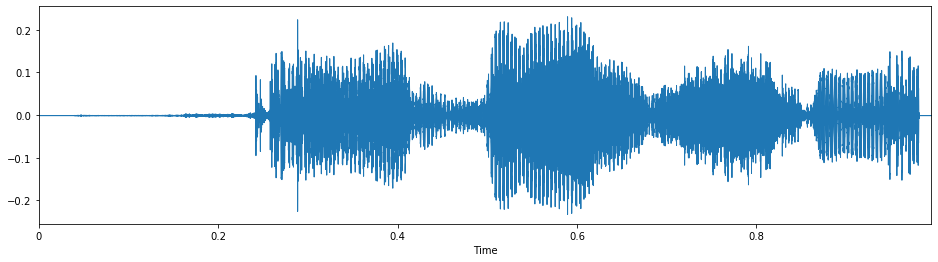

In [82]:
A = wav
print(np.shape(A))
librosa.display.waveplot(A, sr=sampling_rate)
Audio(A, rate=sampling_rate)

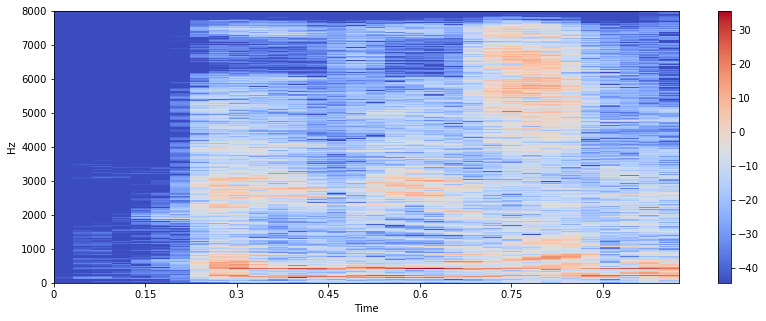

In [83]:
X = librosa.stft(A)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

(16000,)


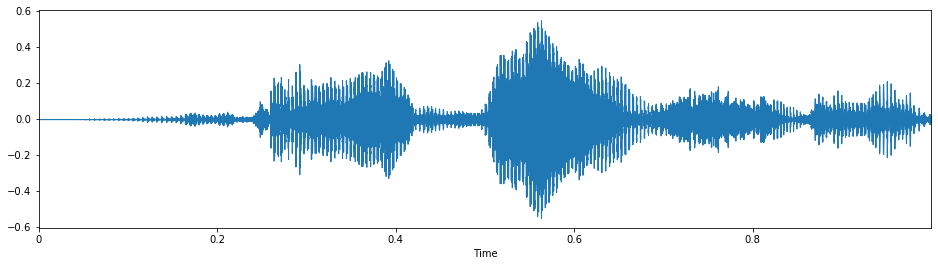

In [84]:
A2B = wav_transformed
print(np.shape(A2B))
librosa.display.waveplot(A2B, sr=sampling_rate)
Audio(A2B, rate=sampling_rate)

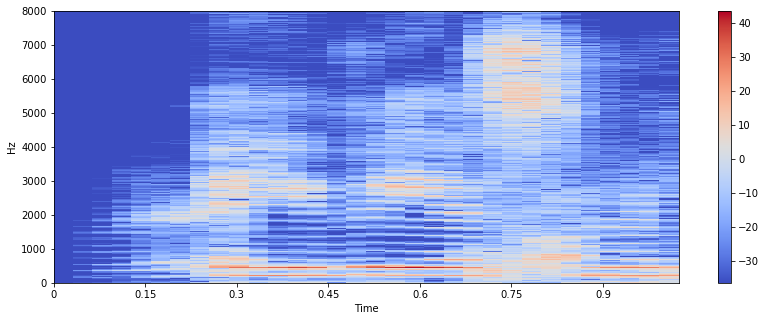

In [85]:
X = librosa.stft(A2B)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

In [86]:
if validation_B_dir is not None:
        print('Generating Validation Data A from B...')
        for file in os.listdir(validation_B_dir):
            filepath = os.path.join(validation_B_dir, file)
            wav, _ = librosa.load(filepath, sr = sampling_rate, mono = True)
            wav = wav_padding(wav = wav, sr = sampling_rate, frame_period = frame_period, multiple = 4)
            f0, timeaxis, sp, ap = world_decompose(wav = wav, fs = sampling_rate, frame_period = frame_period)
            f0_converted = pitch_conversion(f0 = f0, mean_log_src = log_f0s_mean_B, std_log_src = log_f0s_std_B, mean_log_target = log_f0s_mean_A, std_log_target = log_f0s_std_A)
            coded_sp = world_encode_spectral_envelop(sp = sp, fs = sampling_rate, dim = num_mcep)
            coded_sp_transposed = coded_sp.T
            coded_sp_norm = (coded_sp_transposed - coded_sps_B_mean) / coded_sps_B_std
            coded_sp_converted_norm = model.test(inputs = np.array([coded_sp_norm]), direction = 'B2A')[0]
            coded_sp_converted = coded_sp_converted_norm * coded_sps_A_std + coded_sps_A_mean
            coded_sp_converted = coded_sp_converted.T
            coded_sp_converted = np.ascontiguousarray(coded_sp_converted)
            decoded_sp_converted = world_decode_spectral_envelop(coded_sp = coded_sp_converted, fs = sampling_rate)
            wav_transformed = world_speech_synthesis(f0 = f0_converted, decoded_sp = decoded_sp_converted, ap = ap, fs = sampling_rate, frame_period = frame_period)
#             librosa.output.write_wav(os.path.join(validation_B_output_dir, os.path.basename(file)), wav_transformed, sampling_rate)
            break

Generating Validation Data A from B...


/root/EmoCycleGAN/utils.py:183: RuntimeWarning: divide by zero encountered in log
  f0_converted = np.exp((np.log(f0) - mean_log_src) / std_log_src * std_log_target + mean_log_target)


(15920,)


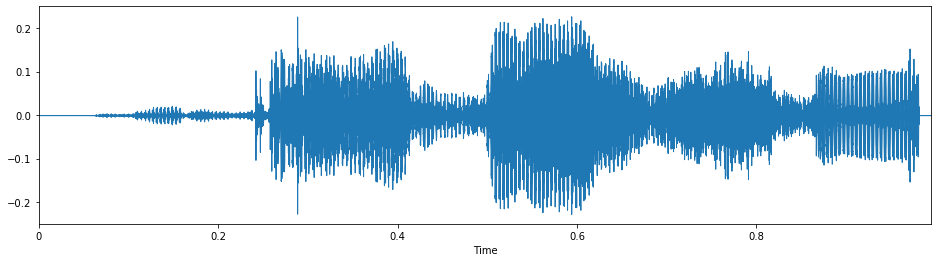

In [87]:
B = wav
print(np.shape(B))
librosa.display.waveplot(B, sr=sampling_rate)
Audio(B, rate=sampling_rate)

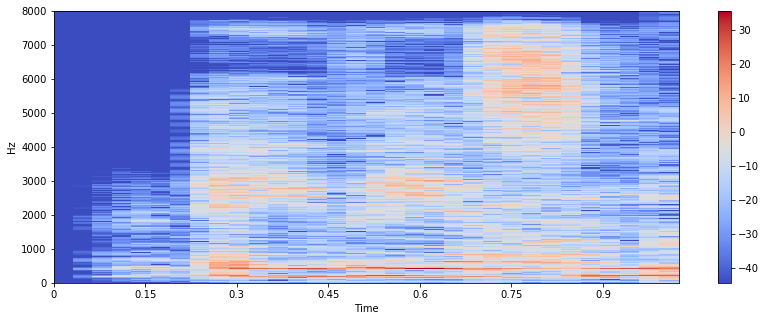

In [88]:
X = librosa.stft(B)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()

(16000,)


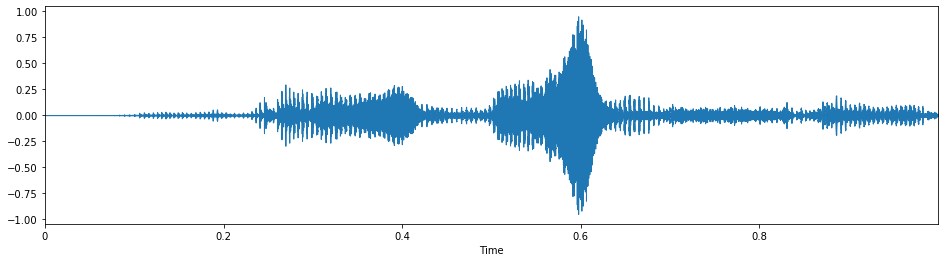

In [89]:
B2A = wav_transformed
print(np.shape(B2A))
librosa.display.waveplot(B2A, sr=sampling_rate)
Audio(B2A, rate=sampling_rate)

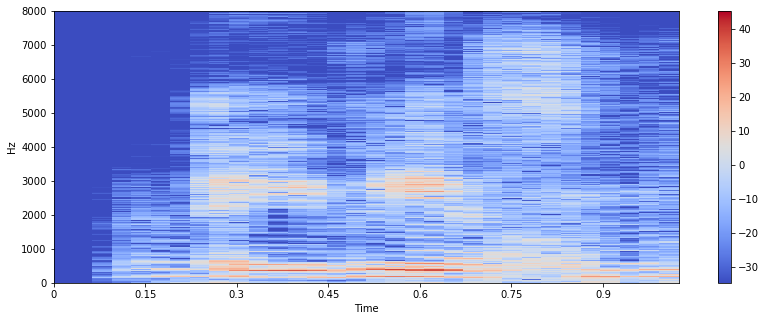

In [90]:
X = librosa.stft(B2A)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')
plt.colorbar()